In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import assert_all_finite
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 
import pandas_datareader.data as web 

In [76]:
start = '2005-01-03'
end = '2018-12-31'
df_aapl = web.DataReader('AAPL', 'yahoo', start, end)

In [77]:
prices = list(df_aapl["Adj Close"])
volume = list(df_aapl["Volume"])

In [78]:
df_aapl.head()

High       Low      Open     Close        Volume  Adj Close
Date                                                                       
2005-01-03  1.162679  1.117857  1.156786  1.130179  6.919920e+08   0.971844
2005-01-04  1.169107  1.124464  1.139107  1.141786  1.096810e+09   0.981825
2005-01-05  1.165179  1.143750  1.151071  1.151786  6.804336e+08   0.990424
2005-01-06  1.159107  1.130893  1.154821  1.152679  7.055552e+08   0.991192
2005-01-07  1.243393  1.156250  1.160714  1.236607  2.227450e+09   1.063362

In [190]:
def macd_func(df):
    df_macd = df.copy()
    exp1 = df_macd["Close"].ewm(span=12, adjust=False).mean() #12 dana EMA (exponential moving average)
    exp2 = df_macd["Close"].ewm(span=26, adjust=False).mean() #26 dana EMA
    macd = exp1-exp2
    signal = macd.ewm(span=9, adjust=False).mean() #9 dana EMA
    
    #macd_array = list(1 * pd.Series(macd - signal > 0).dropna()) #0 kada je macd linija ispod signal linije, inace 1
        
    return macd.tolist(), signal.tolist() 

In [100]:
macd, signal = macd_func(df_aapl[100:150])

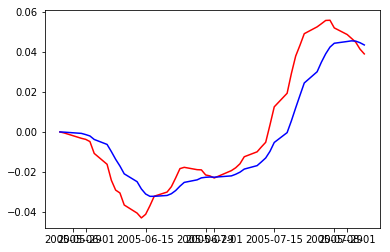

In [99]:
plt.plot(macd, color = 'red')
plt.plot(signal, color='blue')
plt.show()

In [82]:
crossed(macd, signal)

5

In [107]:
def crossed(price1, price2):
    counter = 0
    presjek = 0
    for i in range(len(price1)):
        if((presjek == 0) and (price1[i] <= price2[i])):
            counter += 1
            presjek = 1
        if((presjek == 1) and (price1[i] > price2[i])):
            counter += 1
            presjek = 0
    return counter

In [178]:
def crossed2(price1, price2):
    for i in range(len(price1)):
        if (price1[i] <= price2[i]):
            return 1 #ako se presjeku vracam 1
    return 0

In [84]:
def stochastic_oscilator(df):
    
    #Racunamo stupac najnize cijene u 14 dana
    df_stochastic = df.copy()
    df_stochastic['L14'] = df_stochastic['Low'].rolling(window=14).min()

    #Racunamo stupac najvise cijene u 14 dana
    df_stochastic['H14'] = df_stochastic['High'].rolling(window=14).max()

    #Racunanje trenutne vrijednosti stohastickog indikatora
    df_stochastic['%K'] = 100*((df_stochastic['Close'] - df_stochastic['L14']) /
                               (df_stochastic['H14'] - df_stochastic['L14']) )

    df_stochastic_serija = df_stochastic["%K"]
        
    return list(df_stochastic_serija.dropna())

In [85]:
def rsi2(close, window_length):
    # računamo razliku između cijena
    delta = pd.Series(close).diff()
    
    # prvi red je NaN pa ga mičemo
    delta = delta[1:] 

    # dijelimo razlike na negativne i pozitivne
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # računamo EMA
    roll_up = up.ewm(span=window_length).mean()
    roll_down = down.abs().ewm(span=window_length).mean()

    # računamo RSI pomoću EMA
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    RSI_adj = RSI[1:]
    
    return RSI_adj

In [86]:
def train(X, y):
    # dijelimo podatke na train i test setove
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # skaliramo podatke
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # tražimo optimalne parametre za naš SVC
    num_features = np.size(X_train_scaled, axis=1)
    param_grid = [
      {'C': [1, 10, 100, 1000], 
       'gamma': [1/num_features, 1, 0.1, 0.01, 0.001, 0.0001], 
       'kernel': ['rbf']},
    ]

    optimal_params = GridSearchCV(
            SVC(), 
            param_grid,
            cv=5,
            scoring='accuracy', # moguće postaviti da traži najbolje rezultate za auc_roc parametar
            verbose=0
        )

    optimal_params.fit(X_train_scaled, y_train)
    
    # optimalni parametri
    C_optimal = optimal_params.best_params_.get('C')
    gamma_optimal = optimal_params.best_params_.get('gamma')
    
    # treniramo naš SVC sa optimalnim parametrima
    rbf_svc = svm.SVC(random_state = 7, C = C_optimal, gamma = gamma_optimal, kernel = 'rbf')
    rbf_svc.fit(X_train_scaled, y_train)
    
    # predikcije našeg modela
    predictions = rbf_svc.predict(X_test_scaled)
    
    # računamo preciznost i točnost
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)
    
    return accuracy, f1, roc_auc

In [203]:
def calc(daysObservation, daysMark, indicator, df_aapl):
    trenutni = []
    
    df = df_aapl.copy()
        
    step = daysObservation + daysMark

    # izračun da se pravilno "namjeste" datumi
    odmak = len(prices) % step

    X = []
    y = []
    prices_observation = []
    for i in range(0, len(prices) - odmak, step):
        prices_observation = prices[i:i+daysObservation]
        prices_observation.extend(volume[i:i+daysObservation]) # dodavanje volumena u X
        
        prices_observation.extend(rsi2(prices[i:i+daysObservation], daysObservation)) #dodavanje rsi u X
        
        #dodavanje stohasticki oscilator u X
        prices_observation.extend(stochastic_oscilator(df_aapl.iloc[i:i+daysObservation]))
        
        X.append(prices_observation)
        
        #oznacavanje perioda promatranja
        macd, signal = macd_func(df[i:i+step]) # računam na svih 35 dana liniju macd i signal
        
        macd_look_forward = macd[daysObservation:step]
        signal_look_forward = signal[daysObservation:step] 
        
        if(crossed2(macd_look_forward, signal_look_forward)): #provjeravam dal se presjekla ta linija u sljedećih 9 dana
            y.append(0) #ako je to označava negativan trend (promjenu trenda)
        else:
            y.append(1) #ako nije ostaje pozitivan (nastavak trenda)

    
    
    accuracy, f1, roc_auc = train(X,y)
    
    return [daysObservation, daysMark, accuracy, f1, roc_auc]


In [204]:
predictions = []
predictions_dict = {}
predictions_list_dict = []
daysObservation_array = [26]
daysMark_array = [9] 

indicator_array =  ['macd']

for indicator in indicator_array:
    for daysObservation in daysObservation_array:
        for daysMark in daysMark_array:
            predictions = calc(daysObservation, daysMark, indicator, df_aapl)
            predictions_dict = {'indicator': indicator, 'days_observed': predictions[0], 'days_marked': predictions[1],
                             'accuracy':predictions[2], 'f1_score':predictions[3], 'auc_roc': predictions[4]}
            predictions_list_dict.append(predictions_dict)

In [205]:
predictions_sorted = sorted(predictions_list_dict, key=lambda k: k['auc_roc'], reverse = True)
for i in predictions_sorted[:20]: #ispis prvih 20 rezultata
    print(i)

{'indicator': 'macd', 'days_observed': 26, 'days_marked': 9, 'accuracy': 0.72, 'f1_score': 0.5333333333333333, 'auc_roc': 0.7017543859649122}
